#### Densest Subgraph Problem

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np


def plot_graph(E, fig_size=5):
    # Create a new graph
    G = nx.Graph()

    # Add edges to the graph
    for (u, v) in E:
        G.add_edge(u, v)

    # Draw the graph
    plt.figure(figsize=(fig_size, fig_size))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()


def plot_graph_adj_list(adj_list, fig_size=5):
    # Add edges to the graph from the adjacency list
    G = nx.DiGraph()
    for u in adj_list:
        for v, weight in adj_list[u]:
            G.add_edge(u, v, weight=weight)
  
    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    plt.show()     



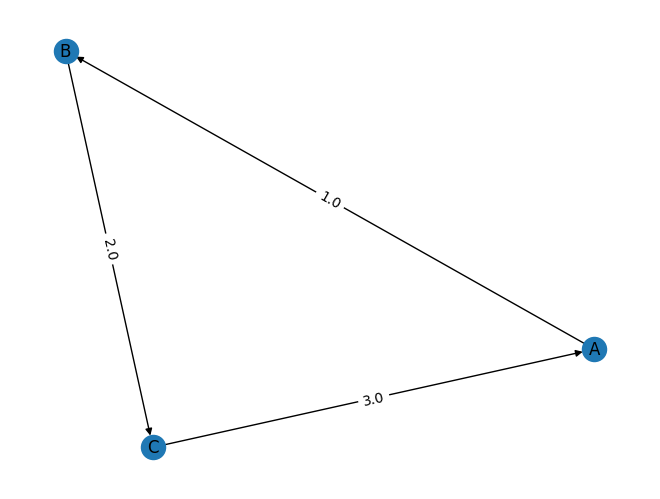

In [11]:
adjacency_list = {
    'A': [('B', 1.0)],
    'B': [('C', 2.0)],
    'C': [('A', 3.0)]
}
plot_graph_adj_list(adjacency_list, fig_size=5)

#### Greedy Peeling (Approximate Algorithm)

In [12]:
class Vertex:
    def __init__(self, id):
        self.id = id
        self.adjacency_list = []
        self.removed = False
        self.degree = 0
        self.degree_list_pointer = None
        self.vertex_list_pointer = None
        self.next = None
        self.prev = None

    def __str__(self):
        return str(self.id)

    def __repr__(self):
        return str(self.id)


class Edge:
    def __init__(self, id, u, v):
        self.id = id
        self.u = u
        self.v = v

    def __str__(self):
        return str((self.u, self.v))

    def __repr__(self):
        return str((self.u, self.v))


# doubly linked list
class LL:
    # linked list of vertices
    def __init__(self):
        self.head = None
        self.tail = None
        self.size = 0

    def add(self, vertex):
        vertex.next = None
        if self.head is None:
            self.head = vertex
            self.tail = vertex
        else:
            self.tail.next = vertex
            vertex.prev = self.tail
            self.tail = vertex
        self.size += 1

    def pop(self):
        if self.head is None:
            return None
        else:
            vertex = self.head
            if vertex.next is not None:
                vertex.next.prev = None
                self.head = vertex.next
            else:
                self.head = None
                self.tail = None
            self.size -= 1
            return vertex

    def remove(self, vertex):
        if vertex.prev is not None:
            vertex.prev.next = vertex.next
        else:
            self.head = vertex.next
            if self.head is not None:
                self.head.prev = None

        if vertex.next is not None:
            vertex.next.prev = vertex.prev
        else:
            self.tail = vertex.prev
            if self.tail is not None:
                self.tail.next = None

        vertex.prev = None
        vertex.next = None
        self.size -= 1

    def __str__(self):
        vlist = []
        if self.head is not None:
            v = self.head
            #v_prev_id = None 
            while v is not None:
                print(f"Current vertex id: {v.id}")  # Debugging line
                vlist.append(v.id)
                #v_prev_id = v.id
                v = v.next
                #if v is not None:
                    #if v_prev_id == v.id:
                    #    print(f"Loop detected at vertex {v.id}")
                    #    break
        return str(vlist)        


# implementation of greedy peeling algorithm for finding densest subgraph
def DS_greedy_peeling(G, verbose=False):
    V, E = G

    # create adjacency list 
    vertex_list = [Vertex(v) for v in V]
    for (u,v) in E:
        vertex_list[u].adjacency_list.append(vertex_list[v])
        vertex_list[v].adjacency_list.append(vertex_list[u])    

    # create array of size |V| to store linked lists containing vertices at each possible degree, keep track of smallest degree
    degree = [LL() for _ in range(len(V))]
    min_degree = len(V)
    for v in vertex_list:
        d = len(v.adjacency_list) # degree of vertex v
        v.degree = d
        v_degree_object = Vertex(v.id)
        v_degree_object.vertex_list_pointer = v
        v.degree_list_pointer = v_degree_object
        degree[d].add(v_degree_object)
        min_degree = min(min_degree, d)

    def print_vertices():
        print("\nVertices:\n")
        for v in vertex_list:
            if v is not None:
                print(f"{v.id}: {v.adjacency_list}")

        print("\nDegrees:\n")
        for i in range(len(degree)):
            if degree[i].size > 0:
                print(f"{i}: {degree[i]}")    

        print(f"Min degree: {min_degree}\n")            

    if verbose:
        print_vertices()

    # peeling iterations
    S = V.copy()
    S_max = V.copy()
    num_vertices = len(V)
    num_edges = len(E)
    max_density = num_edges / num_vertices

    iters = 0
    while len(S) > 0 and min_degree < len(V):
        iters += 1
        if degree[min_degree].size == 0:
            min_degree += 1
            continue

        # get min degree vertex
        v_degree = degree[min_degree].pop()
        # use pointer to get vertex list object
        v = v_degree.vertex_list_pointer
        # mark the vertex list object as removed and zero out it's degree
        v.removed = True
        v.degree_list_pointer = None
        v.degree = 0
        #print(f"Removed vertex {v.id} with degree {min_degree}")
        
        # update the degree of neighbors
        for w in v.adjacency_list:
            if not w.removed:
                #print(f"Updating degree of vertex {w.id} from {w.degree} to {w.degree-1}")
                # current degree of w
                d = w.degree 
                # new degree of w
                w.degree -= 1    
                # use pointer to jump to the correct linked list in degree array
                w_degree = w.degree_list_pointer
                # remove w_degree from current linked list
                degree[d].remove(w_degree)
                # add w_degree to degree d-1 linked list     
                degree[d-1].add(w_degree)
                
        # empty out adjacency list of v
        v.adjacency_list = []

        # update S
        S.remove(v.id)
        # update density
        num_vertices -= 1
        num_edges -= min_degree
        density = num_edges / num_vertices
        if density > max_density:
            max_density = density
            S_max = S.copy()

        if verbose:
            print(f"Removed vertex {v.id} with degree {min_degree}")
            print(f"New density: {density}")
            print(f"Remaining vertices: {S}")
            print("\nDegrees:\n")
            for i in range(len(degree)):
                if degree[i]:
                    print(f"{i}: {degree[i]}")  

    # get max density subgraph edge set
    Es = []
    for i in range(len(S_max)-1):
        u = S_max[i]
        for j in range(i+1, len(S_max)):
            v = S_max[j]
            if (u, v) in Es:
                Es.append((u,v))
            if (v, u) in Es:
                Es.append((v,u))     

    Gs = (S_max, Es)        

    print(f"\nMax density subgraph found with greedy peeling: {max_density}\n")
    return max_density, Gs



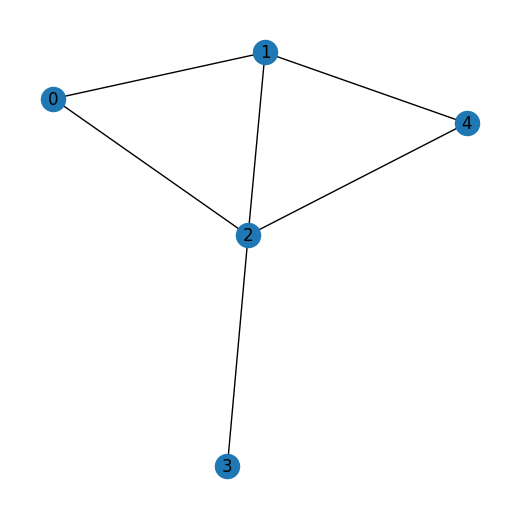

In [13]:
random.seed(0)

# example graph

# create a random undirected connected graph with vertex size N
"""
N = 6
V = list(range(N))
E = []
for i in range(N):
    for j in range(i+1, N):
        if random.random() < 0.5:
            E.append((i,j))
G = (V,E)
"""

V = [0,1,2,3,4,5]
E = [(0,1), (0,2), (1,2), (2,3), (1,4), (2,4)]
G = (V,E)

# plot the graph
plot_graph(E, fig_size=5)

In [14]:
# test greedy peeling algorithm
DS_greedy_peeling(G, verbose=False)


Max density subgraph found with greedy peeling: 1.25



(1.25, ([0, 1, 2, 4], []))

#### Max-Flow Based Densest Subgraph (Exact Algorithm)

In [15]:
# use BFS to find path from s to t in Gf
def find_st_path(adjacency_list, s, t):
    assert (s >= 0 and s < len(adjacency_list)), "s is out of range"
    # initialize all vertices as undiscovered except for s
    discovered = [False] * len(adjacency_list)
    discovered[s] = True
    parent = [None] * len(adjacency_list)
    # intiialize BFS queue
    Q = []
    Q.append(s)
    # initialize s-t path
    path = []
    # run BFS
    while len(Q)>0:
        # pop vertex from front of queue
        u = Q.pop(0)
        # find vertices adjacent to u and add them to the Q if they are undiscovered
        for (v,ce) in adjacency_list[u]:
            if not discovered[v]:
                discovered[v] = True
                parent[v] = (u, ce)
                # if v is t, then we have found the path
                if v == t:
                    # reconstruct path from s to t following parent pointers
                    while parent[t] != None:
                        # add edge to path
                        edge = (parent[t][0], t, parent[t][1])
                        path.append(edge)
                        t = parent[t][0]
                    return path
                # add to Q
                Q.append(v)
 
    # if we reach here, then there is no s-t path
    return path            


def construct_residual_graph(adjacency_list, flow, capacity):
    Gf_adjacency_list = {u:[] for u in adjacency_list.keys()}
    for u in range(len(adjacency_list)):
        for (v, ce) in adjacency_list[u]:
            # add forward edge if there's non-zero residual capacity
            residual_ce = capacity[(u, v)] - flow[(u, v)]
            if residual_ce > 0:
                Gf_adjacency_list[u].append((v, residual_ce))
            # add backward edge if there's non-zero flow 
            if flow[(u, v)] > 0:
                Gf_adjacency_list[v].append((u, flow[(u, v)]))

    return Gf_adjacency_list            


# max flow algorithm
def DS_max_flow(G, lmbda, verbose=False, max_iters=10000):
    V, E = G # V is a list of vertices, E is a list of undirected edges
    #print(f"Vertices in G: {V}")
    #print(f"Undirected edges in G: {E}")

    # construct flow network H
    H_vertex_dict = {'s':0, 't':1} # dictionary for mapping vertex string labels to integer ids
    id_next = 2
    H_adjacenecy_list = {0:[], 1:[]}

    # create vertex nodes: Y
    Y = []
    for v in V:
        # create new vertex node for vertex v
        label = 'y_'+str(v)
        H_vertex_dict[label] = id_next
        Y.append(id_next)
        # add to adjacency list and create an edge connecting to sink of unit cpacity
        H_adjacenecy_list[id_next] = [(H_vertex_dict['t'], 1)]
        id_next += 1
        
    # create edge nodes: X
    X = []
    for (u,v) in E:
        # create new edge node for edge (u, v)
        label = 'x_'+str((u,v))
        H_vertex_dict[label] = id_next
        X.append(id_next)
        # create edge connecting source to edge node with capacity lambda
        H_adjacenecy_list[H_vertex_dict['s']].append((H_vertex_dict[label], lmbda))
        # create edges connecting edge node x_(u,v) to vertex nodes y_u and y_v with infinite capacity
        H_adjacenecy_list[H_vertex_dict[label]] = [(H_vertex_dict['y_'+str(u)], float('inf')), (H_vertex_dict['y_'+str(v)], float('inf'))]
        #H_adjacenecy_list[H_vertex_dict[label]] = [(H_vertex_dict['y_'+str(u)], 2), (H_vertex_dict['y_'+str(v)], 2)]
        id_next += 1

    H_vertex_dict_inv = {v:k for k,v in H_vertex_dict.items()}

    #print(f"Edge nodes, X: {X}, Labels: {[H_vertex_dict_inv[x] for x in X]}")
    #print(f"Vertex nodes, Y: {Y}, Labels: {[H_vertex_dict_inv[y] for y in Y]}")
    #print(f"H adjacency list: {H_adjacenecy_list}")

    # construct adjacency list
    adjacency_list = H_adjacenecy_list

    # initialize the flow to 0
    flow = {}
    capacity = {}
    for u in adjacency_list.keys():
        for (v, ce) in adjacency_list[u]:
            flow[(u, v)] = 0
            capacity[(u, v)] = ce

    # construct residual graph
    Gf_adjacency_list = construct_residual_graph(adjacency_list, flow, capacity)
    if verbose:
        print("Initial residual graph:")
        print(Gf_adjacency_list)

    # get source and sink vertices
    s = H_vertex_dict['s']
    t = H_vertex_dict['t']

    num_iterations = 0
    # run augmenting iterations
    while True:
        # find s-t path in Gf
        path = find_st_path(Gf_adjacency_list, s, t)
        # if there is no s-t path, then we are done
        if len(path) == 0:
            if verbose:
                flow_value = sum([flow[(s, v)] for (v, _) in adjacency_list[s]])
                print(f"\nMax flow found! |f| = {flow_value}, total iterations = {num_iterations}")
            break
        else:
            # find bottleneck capacity of path
            bottleneck_capacity = float('inf')
            for (u, v, ce) in path:
                if ce < bottleneck_capacity:
                    bottleneck_capacity = ce
            # augment flow along path
            for (u, v, ce) in path:
                if (u, v) in capacity:
                    # increase flow along forward edge (u, v)
                    flow[(u, v)] += bottleneck_capacity
                else:
                    # decrease flow along backward edge (v, u)
                    flow[(v, u)] -= bottleneck_capacity 
            # construct updated residual graph        
            Gf_adjacency_list = construct_residual_graph(adjacency_list, flow, capacity)     
            
            if verbose:
                print(f"\nFlow augmented along path: {path} by amount: {bottleneck_capacity}")
                print(f"New residual graph: \n {Gf_adjacency_list}")
                print(f"Augmented Flow: \n {flow}")   

            num_iterations += 1   
            if num_iterations > max_iters:
                print(f"Max iterations reached! |f| = {sum([flow[(s, v)] for (v, _) in adjacency_list[s]])}")
                break    


    # get min-cut
    S = [0]
    for v in adjacency_list.keys():
        if find_st_path(Gf_adjacency_list, s, v):
            S.append(v)
    T = [v for v in adjacency_list.keys() if v not in S]
    # get induced subgraph vertices
    A = [v for v in Y if v in S]
    # get edge nodes corresponding to induced subgraph edges
    E_A = [v for v in X if v in S]

    # get min-cut edges
    min_cut_edges = []
    for u in S:
        for (v, ce) in adjacency_list[u]:
            if v in T:
                min_cut_edges.append((u, v))
    min_cut_capacity = sum([capacity[(u, v)] for (u, v) in min_cut_edges])

    # map back to original vertex labels, strip off 'y_' prefix and convert string to integer
    V_s = [int(H_vertex_dict_inv[id].split('_')[1]) for id in A]
    # get induced subgraph edges
    E_s = []
    for (u, v) in E:
        if u in V_s and v in V_s:
            E_s.append((u, v))
    # induced subgraph density
    rho_s = len(E_s) / len(V_s) if len(V_s) > 0 else 0

    if verbose:
        #print(f"\nMin-cut vertices --> S = {S}, T = {T}")
        #print(f"|X| = {len(X)}, |Y| = {len(Y)}")
        print(f"Min-cut vertices --> |S| = {len(S)}, |T| = {len(T)}, Actual Cut Capacity = {min_cut_capacity}")
        #print(f"Min-cut edges: {min_cut_edges}, Actual Cut Capacity = {min_cut_capacity}")
        #print(f"A = {A}, E(A) = {E_A}")
        print(f"|A| = {len(A)}, |E(A)| = {len(E_A)}")
        print(f"Predicted Min-cut Capacity = |A| + lambda (|E|- |E(A)|) = {len(A) + lmbda * (len(E) - len(E_A))}")
        print(f"Lambda * |E| = {lmbda * len(E)}\n")    
        #print(f"Induced subgraph vertices: {V_s}")
        #print(f"Induced subgraph edges: {E_s}")
        print(f"Induced subgraph density: {rho_s}, Inverse lambda: {1/lmbda}")

    # max-flow
    max_flow = {}
    for u in adjacency_list.keys():
        for (v, ce) in adjacency_list[u]:
            max_flow[(u, v)] = flow[(u, v)] 

    return rho_s, V_s, E_s 


In [16]:
def create_random_graph(n, dE = None):
    # first create a fully connected undirected graph
    V = list(range(n))
    E = []
    for i in range(n):
        for j in range(i+1, n):
            E.append((i,j))

    # now create an adjacenecy list
    adjacency_list = {u:[] for u in V}
    for (u, v) in E:
        # add forward edge
        adjacency_list[u].append(v)
        adjacency_list[v].append(u)

    if dE is None:
        # pick a random integer between 1 and (n-1)*(n-2)/2
        del_E = random.randint(1, (n-1)*(n-2)//2)
    else:
        del_E = dE
        assert del_E >= 0 and del_E <= (n-1)*(n-2)//2, "Invalid number of edges to delete"

    print(f"Creating random connected graph with {n} vertices and {len(E)-del_E} edges")

    # ramdomly delete del_E edges without creating isolated vertices
    while del_E > 0:
        u = random.randint(0, n-1)
        v = random.randint(0, n-1)
        if (u != v) and len(adjacency_list[u]) > 1:
            if v in adjacency_list[u] and len(adjacency_list[v]) > 1: 
                adjacency_list[u].remove(v)
                adjacency_list[v].remove(u)
                del_E -= 1

    # create edge list
    E = []
    for u in adjacency_list.keys():
        for v in adjacency_list[u]:
            if u < v:
                E.append((u, v))

    # maximum possible density for a connected graph with n vertices is 2*(n-1)/n
    max_density = (n-1)/2
    print(f"Current density of graph: {len(E) / n}")
    print(f"Max possible density for graph with {n} vertices: {max_density}\n")

    return (V, E)        

#### Binary search for optimal parameter: $\lambda^{*} = \frac{1}{\rho(G_s)_{OPT}}$

In [49]:
# test parameteric max flow algorithm


def brute_force_search(G):
    V, E = G
    n = len(V)

    # lambda search space
    l_min = 2 / (n-1) 
    l_max = 2
    delta = (0.99 / (n-2)) # slightly less than 1/(n-2) to avoid floating point errors
    lmbda = np.arange(l_min, l_max, delta) 
    #lmbda = np.arange(0.12, 0.15, 0.001) 
    print(f"lambda_min: {l_min}, lambda_max: {l_max}, delta: {delta}")

    rho_s = []
    G_s = []
    rho_max = 0

    pbar = tqdm(total=len(lmbda))
    for l in lmbda:
        #print("\n----------------------------------------------------------")
        #print(f"Solving densest subgraph problem for lambda = {l}")
        rho, V, E = DS_max_flow(G, l, verbose=False)
        rho_s.append(rho)
        G_s.append((V, E))
        if rho > rho_max:
            rho_max = rho
            G_s_max = (V, E)    
        #print("----------------------------------------------------------\n")

        pbar.update(1)
        pbar.set_description(f"Lambda: {l:.2f}, Density: {rho:.2f}")

    print(f"\nMax density subgraph found using brute force search: {rho_max}\n")

    # plot the density of the densest subgraph as a function of lambda
    """
    plt.figure(figsize=(10, 5))
    plt.plot(lmbda, rho_s)
    plt.xlabel('Lambda')
    plt.ylabel('Density(G_s)')
    plt.title('Density of Max Flow Induced Subgraph vs Lambda')
    plt.show()
    """
    return rho_max, G_s_max


def binary_search(G):
    V, E = G
    n = len(V)

    # lambda search space
    l_min = 2 / (n-1) 
    l_max = 2
    delta = (0.99 / (n-2)) # slightly less than 1/(n-2) to avoid floating point errors

    print(f"lambda_min: {l_min}, lambda_max: {l_max}, delta: {delta}")

    rho_max = 0
    Gs_max = None

    total_iterations = np.ceil(np.log2((l_max - l_min) / delta))
    pbar = tqdm(total=total_iterations)
    while True:
        l = (l_min + l_max) / 2
        #print(f"l_min: {l_min}, l_max: {l_max}, l: {l}")
        rho, V, E = DS_max_flow(G, l, verbose=False)
        if rho > rho_max:
            rho_max = rho
            Gs_max = (V, E)

        # Update the progress bar
        pbar.update(1)
        pbar.set_description(f"Lambda: {l:.2f}, Density: {rho:.2f}")

        # once we have found the densest subgraph which has density = 1/lambda_star, we can stop
        # lambda_star will be in the range [l_min, l_max] when l_min and l_max are at least delta close to each other     
        if l_max - l_min < delta:
            break
        # if density is less than 0.5 (i.e. zero), then we need to increase lambda    
        if rho < 0.5: # if rho == 0 :
            l_min = l
        # otherwise we can lower lambda
        else:
            l_max = l


    print(f"\nMax density subgraph found with binary search: {rho_max}\n")
    return rho_max, Gs_max


#random.seed(1234567)
n = 50 
G = create_random_graph(n, dE=n**2//2.45) 
V, E = G
# plot the graph
#plot_graph(E, fig_size=5)

rho_max_greedy, G_s_max_greedy = DS_greedy_peeling(G)
rho_max_brute, G_s_max_brute = brute_force_search(G)
rho_max_binary, G_s_max_binary = binary_search(G)

print(f"Brute force search matches binary search: {rho_max_brute == rho_max_binary}")


Creating random connected graph with 50 vertices and 205.0 edges
Current density of graph: 4.1
Max possible density for graph with 50 vertices: 24.5


Max density subgraph found with greedy peeling: 4.217391304347826

lambda_min: 0.04081632653061224, lambda_max: 2, delta: 0.020625


Lambda: 1.98, Density: 4.10: 100%|██████████| 95/95 [00:02<00:00, 44.98it/s]



Max density subgraph found using brute force search: 4.266666666666667

lambda_min: 0.04081632653061224, lambda_max: 2, delta: 0.020625


Lambda: 0.23, Density: 0.00: : 8it [00:00, 28.84it/s]


Max density subgraph found with binary search: 4.266666666666667

Brute force search matches binary search: True
